In [1]:
# Test using cj877 COSIMA DB with the ocean and atmosphere files
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr

%load_ext memory_profiler

In [2]:
def annual_mean(ds):
    """ Properly month length weighted annual mean of a DataArray"""
    month_length = ds.time.dt.days_in_month
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds*weights).groupby('time.year').sum(dim='time',min_count=1)
    return ann_mean

def global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    ds_w = ds.weighted(weights.fillna(0))
    return ds_w.mean(['yt_ocean', 'xt_ocean'])

def atm_global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    ds_w = ds.weighted(weights.fillna(0))
    return ds_w.mean(['lat', 'lon'])

In [3]:
session = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt = 'cj877'

In [4]:
%%memit

sst = cc.querying.getvar(expt, 'surface_pot_temp', session, end_time='0010-12-31', frequency='1 monthly', use_cftime=True)
area_t = cc.querying.getvar(expt, 'area_t', session, n=1)

peak memory: 332.03 MiB, increment: 72.87 MiB


peak memory: 693.76 MiB, increment: 361.51 MiB


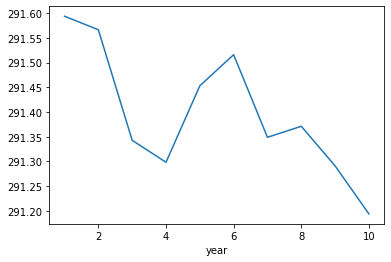

In [5]:
%%memit

# This order is slightly faster and uses less memory than the alternative of 
# annual mean and then global mean
sst_g = global_mean(sst, area_t)
sst_a = annual_mean(sst_g)
sst_a.load()
sst_a.plot()


In [6]:
%%memit

# Atmospheric model surface air temperature
tas = cc.querying.getvar(expt, 'fld_s03i236', session, end_time='0010-12-31', use_cftime=True)
area_a = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc').areacella


peak memory: 2249.12 MiB, increment: 1554.58 MiB


peak memory: 2250.18 MiB, increment: 1.03 MiB


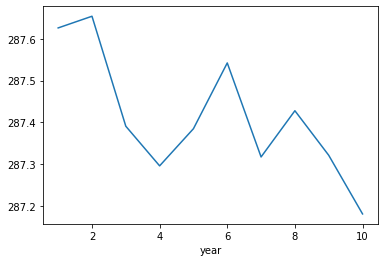

In [7]:
%%memit

tas_g = atm_global_mean(tas, area_a)
tas_a = annual_mean(tas_g)
tas_a.load()
tas_a.plot()


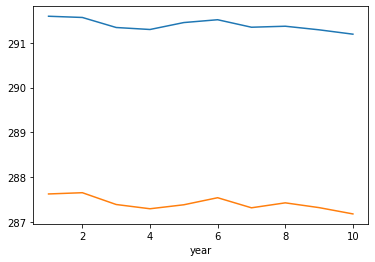

In [8]:
sst_a.plot()
tas_a.plot()